## IQ modulator demo
* IQ modulator is widely used in coherent optical communications.
* We can use an IQ modulator to generate signals with advanced modulation formats such as QPSK, and m-QAMs.

## What we are going to learn in this notebook
* Understand how I/Q modulator works
* Generate I/Q signals, use numpy function 'fft' for Discrete Fourier Transform.
* Apply I/Q signals to I/Q modulator model
* Plot output signals

## How I/Q modulator works

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://aemstatic-ww1.azureedge.net/content/dam/lw/print-articles/volume-32/issue-2/1503LWcovrStoryF2.jpg.scale.MEDIUM.jpg")

[1] https://www.lightwaveonline.com/articles/print/volume-32/issue-2/features/optical-iq-modulators-for-coherent-100g-and-beyond.html

## Generate I/Q signals
* pattern mapping
* raised cosine filter for pulse shaping (roll-off factor 0.2)

Populating the interactive namespace from numpy and matplotlib


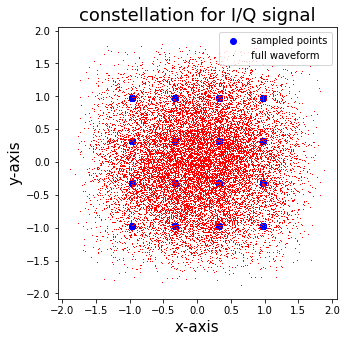

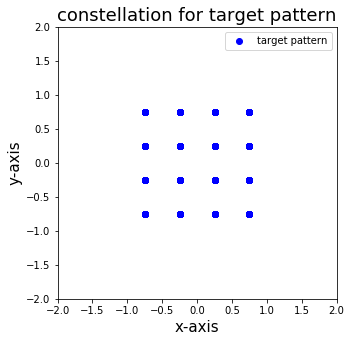

In [2]:
%pylab inline

def makeQAMtarget(shift=0.,N = 2**31,BaudRate = 30, BD=2,beta=.1,half=False,pat_en=None,ModNumber=2,get_rid_DC=None,DEBUG = False):
    """
    In this particular example, we generate 16-QAM signals.
    We can also generate M-QAM signals.
    """
    if pat_en is None:
        Np = int((N)/BD)
        random.seed(103231)
        pattern = (random.randn(Np)>0) + 1j*(random.randn(Np)>0) # QPSK
        pattern -= .5+.5j
        p1 = (random.randn(Np)>0) + 1j*(random.randn(Np)>0)
        p1 -= .5+.5j
        pattern += p1*.5 # 16QAM
        p1 = (random.randn(Np)>0) + 1j*(random.randn(Np)>0)
        p1 -= .5+.5j
        #pattern += p1*.25 # 64QAM
    else:
        pattern1=io.loadmat(pat_en)
        pattern = pattern1['a'][:,0]
        pattern -= np.mean(pattern)
        pattern /=(mean(abs(pattern)**2))**0.5
        if ModNumber==1:
            pattern=roll(pattern,len(pattern)//2)
    
    SampleRate = 2.*BaudRate
    br = BD/SampleRate
    N = int(len(pattern)*BD)
    f = arange(-N/2,N/2)/N*SampleRate
    e = zeros(N,complex)
    e[::int(BD)] = pattern
    s = fft.fftshift(fft.fft(e))
    #plot(f,)
    shaping_filter = RCFilter(beta,f,br)
    if DEBUG:
        figure(figsize = (5,2))
        plot(f,shaping_filter)
    s *=shaping_filter
    if half:
        s*= f>0
    if get_rid_DC:
        s*= abs(f)>10
    #pre-emphasis for dac roll off
    et = fft.ifft(fft.fftshift(s))
    et /= mean(abs(et)**2)**.5
    return f,et,pattern 

def RCFilter(beta,f,T):
    """
    raised-cosine filter for pulse shaping
    """
    H = zeros(len(f),dtype = complex)
    finner = abs(f)<=((1-beta)/2./T)
    fmiddle = (abs(f)>=((1-beta)/2./T))&(abs(f)<=((1+beta)/2./T))
    H[finner] = 1
    H[fmiddle] = 1./2*(1+cos(pi*T/beta*(abs(f[fmiddle])-(1-beta)/2./T)))
    
    return H

## et is
f,et,pattern = makeQAMtarget(shift = 0.,
                             N = 2**15,
                             BaudRate = 30.,
                             BD = 2.,
                             beta = 0.2,
                             half = False,
                             DEBUG = False)

figure(1,figsize = (5,5))
plot(real(et[::2]),imag(et[::2]),'bo',label = 'sampled points')
plot(real(et),imag(et),'r,',label = 'full waveform')
title('constellation for I/Q signal',fontsize = 18)
xlabel('x-axis',fontsize = 15)
ylabel('y-axis',fontsize = 15)
legend()

figure(2,figsize = (5,5))
plot(real(pattern),imag(pattern),'bo',label = 'target pattern')
title('constellation for target pattern',fontsize = 18)
xlabel('x-axis',fontsize = 15)
ylabel('y-axis',fontsize = 15)
xlim(-2,2)
ylim(-2,2)
legend()


## Apply generated signals to I/Q modulator model
* practical model includes modulator bias, 90 degree phase shifter, Vpi, Driver amplitude and OSNR
* practical model includes polarization modulator (here we assume time-invariant polarization shift).

## Plot output signals

In [3]:
def Pol_Emu(e_te,e_tm,theta,baudrate):
    """
    polarization emulator (only with time-invariant polarization shift)
    e_te: TE signal
    e_tm: TM signal
    theta: polarization rotating angle
    """
    N = len(e_te)
    dt = 1./2/baudrate
    t = arange(0,N)*dt
    c  = cos(theta)
    s = sin(theta)
    
    eH = e_te*c+e_tm*s
    eV = -e_te*s+e_tm*c
    
    return eH,eV

def TX_SIMU(efull,N = 2**15,Bias_I = 0.,Bias_Q = 0.,TX_90 = pi/2.,Driver_Amp = 2,Vpi = 4.,OSNR = 20.,theta = 0.):
    '''
    et is the full pattern
    N is the data length that we used for the pattern, and it started with a initial value
    Bias_I is the bias phase shifter of the I side
    Bias_Q is the bias phase shifter of the Q side
    TX_90 is the phase shifter of 90 degree phase shifter
    Driver_Amp is the driver output amplitude
    Vpi is the Voltage needed for pi phase shift of the MZM (I/Q)
    '''
    initial_index = mod(floor(random.randn()*2**15),2**15) 
    if mod(initial_index,2) == 1:
        initial_index -= 1
    
    initial_index = int(initial_index)
    e = efull[initial_index:initial_index+N]
    Ph_I = real(e)*Driver_Amp+Bias_I
    Ph_Q = imag(e)*Driver_Amp+Bias_Q
    
    eout = 0.5*(sin(0.5*Ph_I/Vpi*pi)+exp(1j*TX_90)*sin(0.5*Ph_Q/Vpi*pi))
    eout1 = roll(eout,380)
    
    ### need to add AWGN based on OSNR (default is 20 dB)
    GBB_temp = 10**((OSNR-10*log10(30.*2./12.5))/10.)
    power_noise = mean(abs(eout)**2.)**.5/(1+GBB_temp)
    print(power_noise)
    noise_add = (random.randn(N)+1j*random.randn(N))*power_noise
    noise_add1 = (random.randn(N)+1j*random.randn(N))*power_noise
    eout_awgn = eout + noise_add
    eout_awgn1 = eout1 + noise_add1
    
    eH,eV = Pol_Emu(eout_awgn,eout_awgn1,theta,30)

    return eH,eV

0.016226785771489192


Text(0.5, 0, 'x-axis')

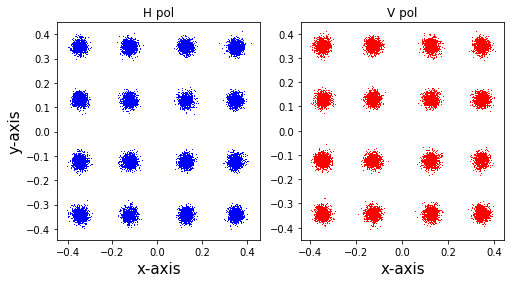

In [4]:
e_full = tile(et,2**6) ### repeat et for 2**6 times
Eout_H,Eout_V = TX_SIMU(efull = e_full,
                        N = int(2**15),
                        Bias_I = 0,
                        Bias_Q = 0,
                        TX_90 = pi/2.,
                        Driver_Amp = 1.,
                        Vpi = 2.,
                        OSNR = 20.,
                        theta = 0.)

figure(1,figsize = (8,4))
subplot(121)
plot(real(Eout_H[::2]),imag(Eout_H[::2]),'b,')
title('H pol')
xlabel('x-axis',fontsize = 15)
ylabel('y-axis',fontsize = 15)

subplot(122)
plot(real(Eout_V[::2]),imag(Eout_V[::2]),'r,')
title('V pol')
xlabel('x-axis',fontsize = 15)
